# BERT model in action
This notebook will go over the how the BERT model classifies twitter data from get old tweets api.

In [1]:
def get_sentiment_dataframe(stock_name = 'msft', first_date="2020-07-13", last_date="2020-07-14"):
    df_stock = pd.DataFrame()
    
    for day_num in range(days_between(first_date, last_date)):
        d1 = first_date
        start_date = str(datetime.strptime(first_date, "%Y-%m-%d")+dt.timedelta(days=day_num ))[:10]
        end_date = str(datetime.strptime(first_date, "%Y-%m-%d")+dt.timedelta(days=day_num+1 ))[:10]
        df = pd.DataFrame()
        df['text'] = get_stock_tweets(stock_name, start_date = start_date, end_date = end_date, max_num=100)
        df_stock[start_date]= get_sentiment_numbers(
            model,
            create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
        )
        
    return df_stock    
    

In [1]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
import pandas as pd
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas_datareader.data as web
from torchtext.data import Field, TabularDataset, BucketIterator

from torch.utils.data import Dataset

import spacy
import json

In [27]:
def sentiment_price(stock_name = 'msft', ticker="msft",first_date="2020-07-05", last_date="2020-07-15"):
    sentiments_df = get_sentiment_dataframe(stock_name=stock_name,first_date=first_date, last_date=last_date).transpose()
    df_stock_price = web.DataReader(ticker, "yahoo", datetime.strptime(first_date, "%Y-%m-%d"), datetime.strptime(last_date, "%Y-%m-%d"))
    result = pd.merge(sentiments_df, df_stock_price, left_index=True, right_index=True, how='outer').dropna()
    result['roe'] = result["Close"]- result["Open"]
    result['sentiment_ratio'] = result[1]/result[0]
    return result

In [6]:
from datetime import datetime
 
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [7]:
import datetime as dt

In [18]:
import GetOldTweets3 as got

def get_stock_tweets(stock_name, start_date = "2020-07-13", end_date = "2020-07-14", max_num = 10):
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(stock_name)\
                                           .setSince(start_date)\
                                           .setUntil(end_date)\
                                           .setMaxTweets(max_num)
    
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    return [tweet.text for tweet in tweets]

In [109]:
def get_sentiment_numbers(model, data_loader):
    model = model.eval()
    
    predictions = []
    
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            #targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds)
            
            
    predictions = torch.stack(predictions).cpu()
    
    return len([x for x in predictions if x ==0])/100,len([x for x in predictions if x ==1])/100

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        #targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [11]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews,  tokenizer, max_len):
        self.reviews = reviews
        #self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        #target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,truncation=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten()#,
         # 'targets': torch.tensor(target, dtype=torch.long)
        }

In [12]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
class_names = [0,1]
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_smal11.bin', map_location=torch.device('cpu')))
model = model.to('cpu')

In [15]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
MAX_LEN = 70
BATCH_SIZE = 16
device='cpu'

In [17]:
def get_sentiment_ratio(model, data_loader):
    model = model.eval()
    
    predictions = []
    
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            #targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds)
            
            
    predictions = torch.stack(predictions).cpu()
    
    len([x for x in predictions if x ==2])
    return len([x for x in predictions if x ==2])/len([x for x in predictions if x ==0])

In [34]:
results = sentiment_price(stock_name = 'amzn',ticker = 'amzn',first_date="2020-07-05", last_date="2020-07-25")

In [35]:
results

,0,1,High,Low,Open,Close,Volume,Adj Close,roe,sentiment_ratio
2020-07-06,38,62,3059.879883,2930.000000,2934.969971,3057.040039,6880600.0,3057.040039,122.070068,1.631579
2020-07-07,42,58,3069.550049,2990.000000,3058.550049,3000.120117,5257500.0,3000.120117,-58.429932,1.380952
2020-07-08,39,61,3083.969971,3012.429932,3022.610107,3081.110107,5037600.0,3081.110107,58.500000,1.564103
2020-07-09,36,64,3193.879883,3074.000000,3115.989990,3182.629883,6388700.0,3182.629883,66.639893,1.777778
2020-07-10,38,62,3215.000000,3135.699951,3191.760010,3200.000000,5486000.0,3200.000000,8.239990,1.631579
2020-07-13,49,51,3344.290039,3068.389893,3251.060059,3104.000000,7720400.0,3104.000000,-147.060059,1.040816
2020-07-14,50,50,3127.379883,2950.000000,3089.000000,3084.000000,7231900.0,3084.000000,-5.000000,1.000000
2020-07-15,52,48,3098.350098,2973.179932,3080.229980,3008.870117,5788900.0,3008.870117,-71.359863,0.923077
2020-07-16,49,51,3032.000000,2918.229980,2971.060059,2999.899902,6394200.0,2999.899902,28.839844,1.040816
2020-07-17,47,53,3024.000000,2948.449951,3009.000000,2961.969971,4761300.0,2961.969971,-47.030029,1.127660


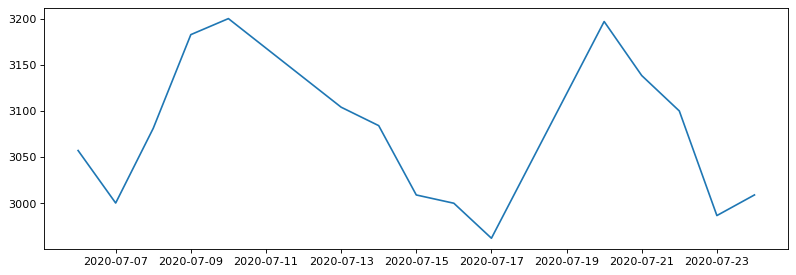

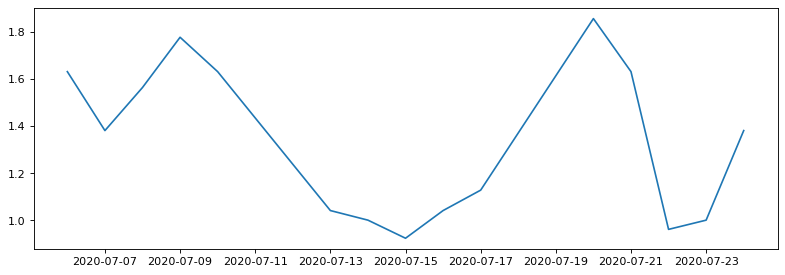

In [36]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(results['Close'])
plt.show()
figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(results['sentiment_ratio'])

In [81]:
financial_report = pd.read_csv('amzn_financial.csv')

In [82]:
financial_report.rename(columns={"Unnamed: 0": "date"}, inplace = True)

In [83]:
financial_report

,date,negative,positive,uncertainty,litigious,constraining,interesting
0,2019-02-01,0.909910,0.972222,0.950820,0.938776,0.973684,0.923077
1,2018-02-02,0.934884,0.971831,0.966667,0.979167,0.974359,1.000000
2,2017-02-10,0.948598,0.958904,0.983051,0.927835,0.923077,0.928571
3,2016-01-29,0.957346,1.000000,0.982759,0.957895,0.972973,0.866667
4,2015-01-30,0.962085,0.986301,0.933333,0.979167,0.972973,0.928571
5,2014-01-31,0.943925,0.958333,0.983051,0.940594,0.972222,1.000000
6,2013-01-30,0.913242,0.985507,0.983051,0.924528,0.916667,0.857143
7,2012-02-01,0.921659,0.985507,0.983051,0.916667,0.941176,1.000000
8,2011-01-28,0.938095,1.000000,0.913793,0.869159,0.969697,0.928571
9,2010-01-29,0.931034,0.942857,1.000000,0.910000,1.000000,1.000000


In [84]:
financial_report.index = financial_report['date']

In [85]:
financial_report.drop('date', axis=1, inplace=True)

In [86]:
financial_report

,negative,positive,uncertainty,litigious,constraining,interesting
date,,,,,,
2019-02-01,0.909910,0.972222,0.950820,0.938776,0.973684,0.923077
2018-02-02,0.934884,0.971831,0.966667,0.979167,0.974359,1.000000
2017-02-10,0.948598,0.958904,0.983051,0.927835,0.923077,0.928571
2016-01-29,0.957346,1.000000,0.982759,0.957895,0.972973,0.866667
2015-01-30,0.962085,0.986301,0.933333,0.979167,0.972973,0.928571
2014-01-31,0.943925,0.958333,0.983051,0.940594,0.972222,1.000000
2013-01-30,0.913242,0.985507,0.983051,0.924528,0.916667,0.857143
2012-02-01,0.921659,0.985507,0.983051,0.916667,0.941176,1.000000
2011-01-28,0.938095,1.000000,0.913793,0.869159,0.969697,0.928571


In [102]:
df = financial_report.merge(results, left_index=True, right_index=True, how="outer").fillna(method ='pad').dropna()


In [108]:
df

,negative,positive,uncertainty,litigious,constraining,interesting,0,1,High,Low,Open,Close,Volume,Adj Close,roe,sentiment_ratio
2020-07-06,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,38.0,62.0,3059.879883,2930.000000,2934.969971,3057.040039,6880600.0,3057.040039,122.070068,1.631579
2020-07-07,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,42.0,58.0,3069.550049,2990.000000,3058.550049,3000.120117,5257500.0,3000.120117,-58.429932,1.380952
2020-07-08,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,39.0,61.0,3083.969971,3012.429932,3022.610107,3081.110107,5037600.0,3081.110107,58.500000,1.564103
2020-07-09,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,36.0,64.0,3193.879883,3074.000000,3115.989990,3182.629883,6388700.0,3182.629883,66.639893,1.777778
2020-07-10,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,38.0,62.0,3215.000000,3135.699951,3191.760010,3200.000000,5486000.0,3200.000000,8.239990,1.631579
2020-07-13,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,49.0,51.0,3344.290039,3068.389893,3251.060059,3104.000000,7720400.0,3104.000000,-147.060059,1.040816
2020-07-14,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,50.0,50.0,3127.379883,2950.000000,3089.000000,3084.000000,7231900.0,3084.000000,-5.000000,1.000000
2020-07-15,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,52.0,48.0,3098.350098,2973.179932,3080.229980,3008.870117,5788900.0,3008.870117,-71.359863,0.923077
2020-07-16,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,49.0,51.0,3032.000000,2918.229980,2971.060059,2999.899902,6394200.0,2999.899902,28.839844,1.040816
2020-07-17,0.90991,0.972222,0.95082,0.938776,0.973684,0.923077,47.0,53.0,3024.000000,2948.449951,3009.000000,2961.969971,4761300.0,2961.969971,-47.030029,1.127660
